mount and imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import pprint
import gensim
import logging
import pickle
# SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# NLTK
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
# KERAS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,Embedding,GRU,LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model,model_from_json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Content
* load data
* preprocess
* tokenize
* padding
* lstm
* predict

# DATA: AMAZON FINE FOOD
active

In [0]:
import sqlite3

In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews --unzip

100% 242M/242M [00:02<00:00, 124MB/s]
100% 242M/242M [00:02<00:00, 122MB/s]


In [0]:
con = sqlite3.connect('/content/database.sqlite')
df = pd.read_sql_query("SELECT * FROM Reviews", con)

In [0]:
df.drop(['Id','ProductId','UserId','ProfileName','Time'],axis=1,inplace=True)
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
df['Usefulness'] = (df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']).apply(lambda x: 'useful' if x>0.7 else 'useless')

In [0]:
df['sentiment'] = df['Score'].apply(lambda x: 'positive' if x>3 else ('negative' if x<3 else 'neutral'))

In [0]:
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Usefulness,sentiment
0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,useful,positive
1,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,useless,negative
2,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,useful,positive
3,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...,useful,negative
4,0,0,5,Great taffy,Great taffy at a great price. There was a wid...,useless,positive


In [0]:
df.columns = ['upvote','totalvote','score','summary','content','usefulness','sentiment']

In [0]:
df

,upvote,totalvote,score,summary,content,usefulness,sentiment
0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,useful,positive
1,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,useless,negative
2,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,useful,positive
3,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...,useful,negative
4,0,0,5,Great taffy,Great taffy at a great price. There was a wid...,useless,positive
...,...,...,...,...,...,...,...
568449,0,0,5,Will not do without,Great for sesame chicken..this is a good if no...,useless,positive
568450,0,0,2,disappointed,I'm disappointed with the flavor. The chocolat...,useless,negative
568451,2,2,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",useful,positive
568452,1,1,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,useful,positive


In [0]:
def describe(amzn):
    emotions = amzn.sentiment.unique()
    emotions_details = []
    for emo in emotions:
        info = {}
        info['feeling'] = emo
        info['count'] = len(amzn[amzn['sentiment']==emo])
        info['mean_len'] = np.mean([len(x.split()) for x in amzn[amzn['sentiment']==emo]['content']])
        emotions_details.append(info)
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(emotions_details)
describe(df)

[   {'count': 443777, 'feeling': 'positive', 'mean_len': 77.29875139991482},
    {'count': 82037, 'feeling': 'negative', 'mean_len': 88.30968953033387},
    {'count': 42640, 'feeling': 'neutral', 'mean_len': 95.64575515947467}]


since dataset is more biased towards positive reviews, let's randomly select 82037 positive, 82037 negative, 42640 neutral

In [0]:
pos_rev = df[df['sentiment']=='positive'].sample(n=82037,axis=0)

In [0]:
amzn = df.drop(df[df.sentiment == 'positive'].index)

In [0]:
amzn = amzn.append(pos_rev)

In [0]:
describe(amzn)

[   {'count': 82037, 'feeling': 'negative', 'mean_len': 88.30968953033387},
    {'count': 42640, 'feeling': 'neutral', 'mean_len': 95.64575515947467},
    {'count': 82037, 'feeling': 'positive', 'mean_len': 77.43601058059168}]


voila!

# Preprocessing
skip for amzn, preprocessed *csv* is saved

In [0]:
stopword = stopwords.words('english')

In [0]:
print(stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [0]:
def clean(text):
    """Remove link,user, special characters and stopwords
    params: string.
    returns: string
    """
    stemmer = SnowballStemmer(language='english')
    text = re.sub('@\S+|https?:\S+|http?:\S|\W+', ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stopword:
            token = stemmer.stem(token)
            tokens.append(token)

    return " ".join(tokens)

In [0]:
%%time
amzn.content = amzn.content.apply(lambda x: clean(x)) # x = each tweet

CPU times: user 2min 34s, sys: 0 ns, total: 2min 34s
Wall time: 2min 34s


In [0]:
amzn.head()

,upvote,totalvote,score,summary,content,usefulness,sentiment
1,0,0,1,Not as Advertised,product arriv label jumbo salt peanut peanut a...,useless,negative
3,3,3,2,Cough Medicine,look secret ingredi robitussin believ found go...,useful,negative
12,1,1,1,My Cats Are Not Fans of the New Food,cat happili eat felida platinum two year got n...,useful,negative
16,0,0,2,poor taste,love eat good watch tv look movi sweet like tr...,useless,negative
26,0,1,1,Nasty No flavor,candi red flavor plan chewi would never buy,useless,negative


saving amzn

In [0]:
amzn.to_csv('/content/drive/My Drive/Colab Notebooks/AI_LAB_PROJECT/Data/amzn.csv')

**Load AMZN** \
it is already processed

In [0]:
amzn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI_LAB_PROJECT/Data/amzn.csv')
amzn.head()

,Unnamed: 0,upvote,totalvote,score,summary,content,usefulness,sentiment
0,1,0,0,1,Not as Advertised,product arriv label jumbo salt peanut peanut a...,useless,negative
1,3,3,3,2,Cough Medicine,look secret ingredi robitussin believ found go...,useful,negative
2,12,1,1,1,My Cats Are Not Fans of the New Food,cat happili eat felida platinum two year got n...,useful,negative
3,16,0,0,2,poor taste,love eat good watch tv look movi sweet like tr...,useless,negative
4,26,0,1,1,Nasty No flavor,candi red flavor plan chewi would never buy,useless,negative


train test split

In [0]:
train,test = train_test_split(amzn,test_size=0.2)

# Keras

In [0]:
SENT_LEN = 100

Tokenization and Padding

In [0]:
tk = Tokenizer(num_words=50000)
tk.fit_on_texts(amzn.content)

In [0]:
MAX_WORDS = len(tk.word_index)+1
print(len(tk.word_index)+1)

51784


In [0]:
X_train = tk.texts_to_sequences(train.content)
X_train = pad_sequences(X_train,maxlen=SENT_LEN,padding='post')

In [0]:
X_train.shape

(165371, 100)

In [0]:
X_test = tk.texts_to_sequences(test.content)
X_test = pad_sequences(X_test,maxlen=SENT_LEN)

One Hot Encoding: Sentiment

In [0]:
y = np.array(amzn.sentiment).reshape(-1,1)
y_train = np.array(train.sentiment).reshape(-1,1)
y_test = np.array(test.sentiment).reshape(-1,1)

In [0]:
onehotenc = OneHotEncoder(categories="auto",handle_unknown='ignore')
onehotenc.fit(y)
y_train = onehotenc.transform(y_train)
y_test = onehotenc.transform(y_test)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/AI_LAB_PROJECT/Data/ohe.pickle', 'wb') as handle:
    pickle.dump(onehotenc, handle, protocol=2)

In [0]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(165371, 100) (165371, 3)
(41343, 100) (41343, 3)


 defining model

In [0]:
model = Sequential()
model.add(Embedding(MAX_WORDS,100,input_length=X_train.shape[1])) # PROBLEM
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(y_test.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          5178400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 5,259,103
Trainable params: 5,259,103
Non-trainable params: 0
_________________________________________________________________


In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

fit

In [0]:
%%time
lstm_3= model.fit(X_train,y_train,batch_size=128,epochs=5,validation_data=(X_test,y_test),verbose=1,callbacks=callbacks)

Train on 165371 samples, validate on 41343 samples
Epoch 1/5
165371/165371 [==============================] - 498s 3ms/step - loss: 1.0309 - acc: 0.4592 - val_loss: 0.9658 - val_acc: 0.5494
Epoch 2/5
165371/165371 [==============================] - 502s 3ms/step - loss: 0.7611 - acc: 0.6818 - val_loss: 0.6895 - val_acc: 0.7141
Epoch 3/5
165371/165371 [==============================] - 497s 3ms/step - loss: 0.5921 - acc: 0.7615 - val_loss: 0.6323 - val_acc: 0.7430
Epoch 4/5
165371/165371 [==============================] - 494s 3ms/step - loss: 0.5201 - acc: 0.7961 - val_loss: 0.6315 - val_acc: 0.7460
Epoch 5/5
165371/165371 [==============================] - 487s 3ms/step - loss: 0.4636 - acc: 0.8218 - val_loss: 0.6214 - val_acc: 0.7528
CPU times: user 1h 15min 14s, sys: 3min 31s, total: 1h 18min 46s
Wall time: 41min 18s


saving trained model

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/AI_LAB_PROJECT/Data/lstm_3_amzn.h5')

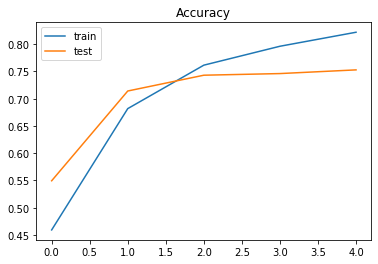

In [0]:
plt.title('Accuracy')
plt.plot(lstm_3.history['acc'], label='train')
plt.plot(lstm_3.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
def predict(text,tkn=0):
    # Tokenize text
    x_test = tk.texts_to_sequences([text])
    x_test = pad_sequences(x_test, maxlen=SENT_LEN)
    # Predict
    pr = model.predict([x_test])
    # taking top two of final predictions
    f_score = pr[pr==np.amax(pr)]
    out = np.max(pr)
    print(out)
    print('fscore', f_score)
    f_label = onehotenc.inverse_transform(pr)
    pr[pr==f_score] = 0
    s_score = pr[pr==np.amax(pr)]
    s_label = onehotenc.inverse_transform(pr)
    return (pr,f_label,s_label)

predicting samples

In [0]:
# negative,neutral,positive
p = "Every once in a while, especially after a longer cook time with liquids still present, some leaking will happen from bag into the slow cooker. But at least it is minimal and cleanup is still super easy!"
n = "These were horrible. bought them for my crockpot. every time i used them (on low heat) they would burn onto the crockpot and it would rip as i was pulling it out. complete mess! do not buy these"
print(predict(p,tkn=1))
print(predict(n,tkn=1))

0.6137179
fscore [0.6137179]
(array([[0.22829242, 0.15798973, 0.        ]], dtype=float32), array([['positive']], dtype=object), array([['negative']], dtype=object))
0.85012877
fscore [0.85012877]
(array([[0.        , 0.08333636, 0.06653486]], dtype=float32), array([['negative']], dtype=object), array([['neutral']], dtype=object))


exporting lstm `model` as HDF5 file, `tokenizer` as .pickle, `onehotenc` as .pickle file

In [0]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/AI_LAB_PROJECT/Data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=2)

# Appendix

save weight + architecture

```
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')
```

Save only architecture
```
# save as JSON
json_string = model.to_json()

# save as YAML
yaml_string = model.to_yaml()
```
Save JSON 
```
import json
my_details = {
    'name': 'John Doe',
    'age': 29
}
with open('personal.json', 'w') as json_file:
    json.dump(my_details, json_file)
```
Load
```
# model reconstruction from JSON:
from keras.models import model_from_json
model = model_from_json(json.dumps(json_string)

# model reconstruction from YAML:
from keras.models import model_from_yaml
model = model_from_yaml(yaml_string)
```